In [195]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [196]:
df = pd.read_csv('../data/at-dataset/final_data.csv')
df = df.set_index('DateTime')
df.index = pd.to_datetime(df.index)

In [197]:
def showFigureEachLaneTraffic(df):
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)
    print(num_lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.set_title(f'Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

def showFigureEachLaneTrafficForOneWeek(df):
    df = df[(df.index > '2024-10-01') & (df.index <= '2024-10-07')]
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)
    print(num_lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.set_title(f'Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

13


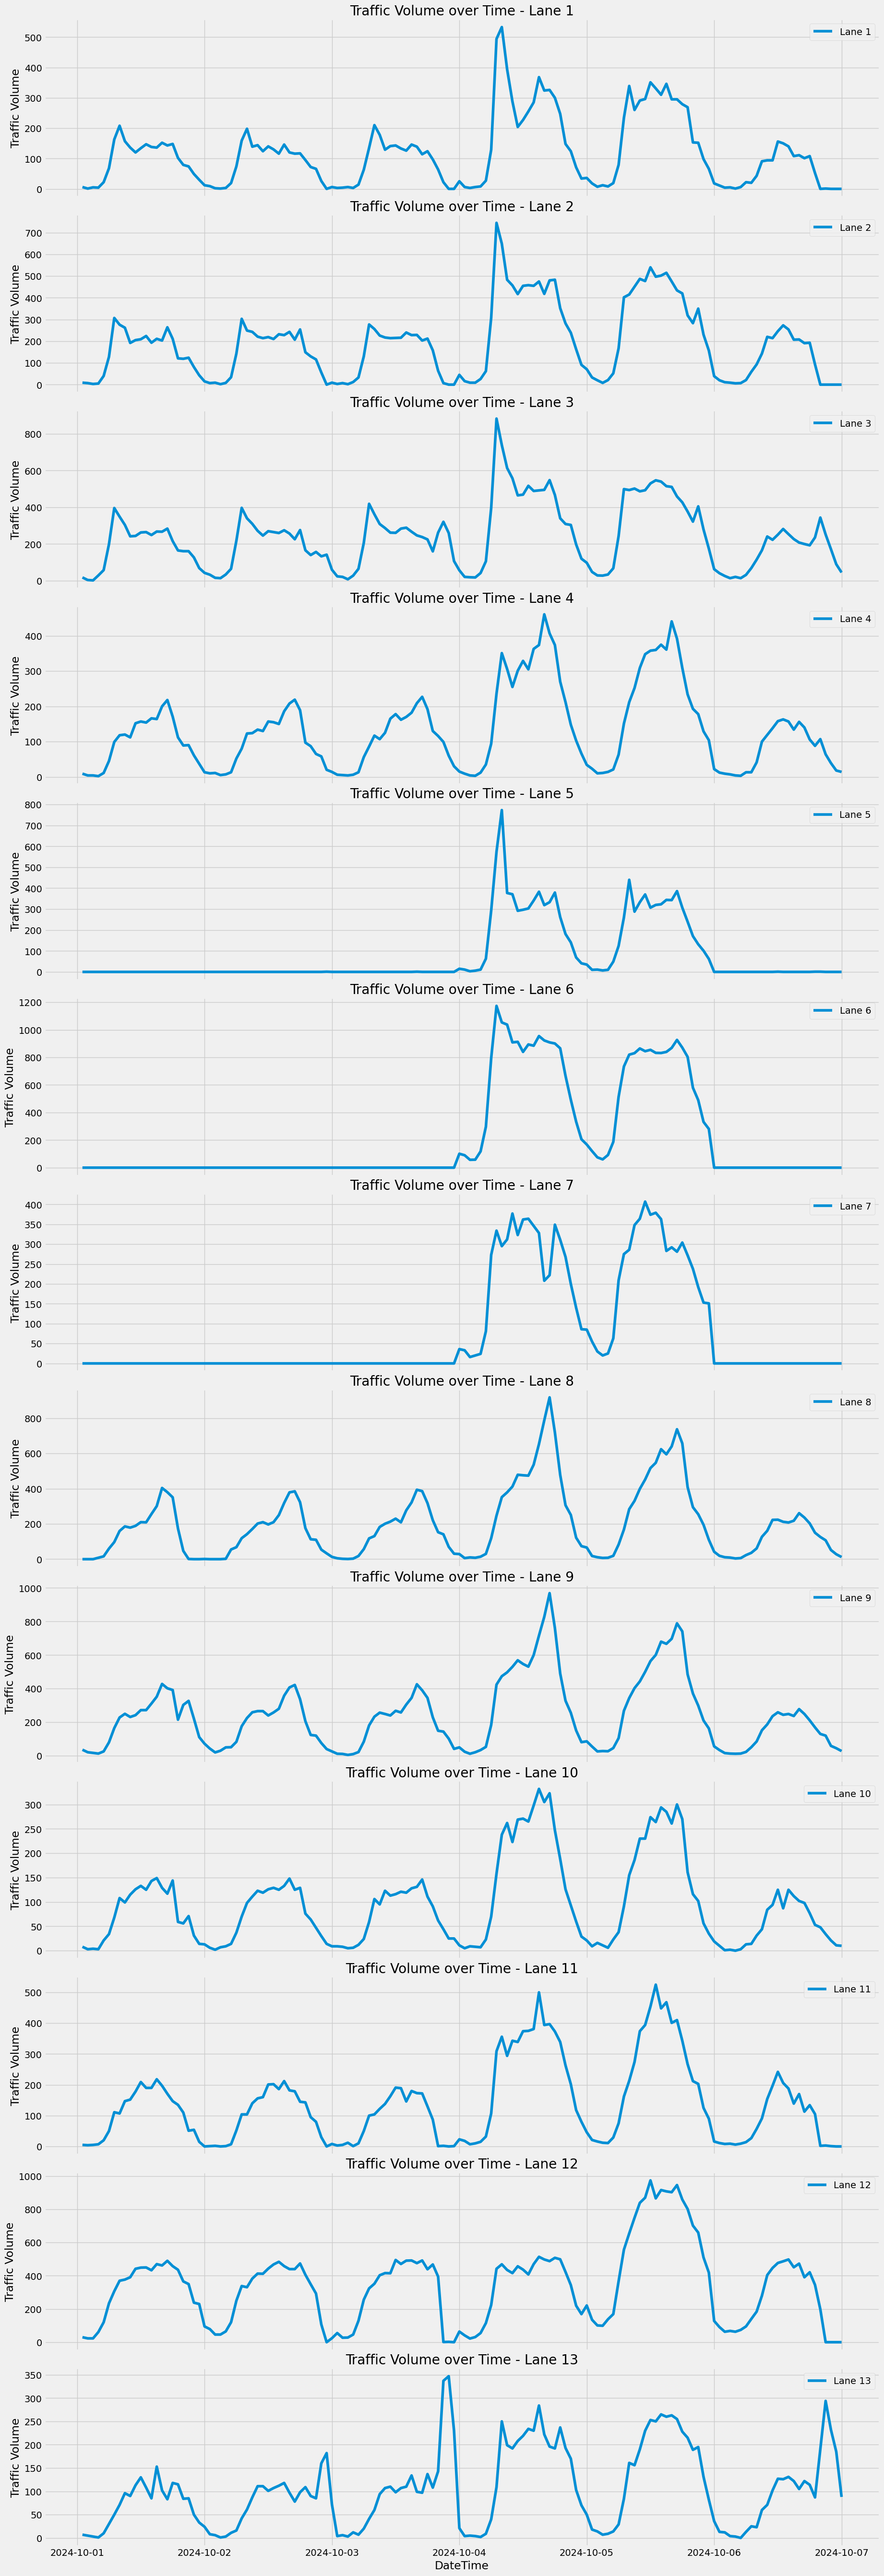

In [198]:
# sub_df = df[(df['Detector_ID'] == 2013) & (df['Lane'] == 1)]
sub_df = df[(df['Detector_ID'] == 2013)]
# & (df.index > '2024-10-01') & (df.index < '2024-12-01')
# sub_df['Volume'].plot(style='.', figsize=(20, 5), title='Traffic Volume over Time', xlabel='DateTime', ylabel='Traffic Volume')
showFigureEachLaneTrafficForOneWeek(sub_df)

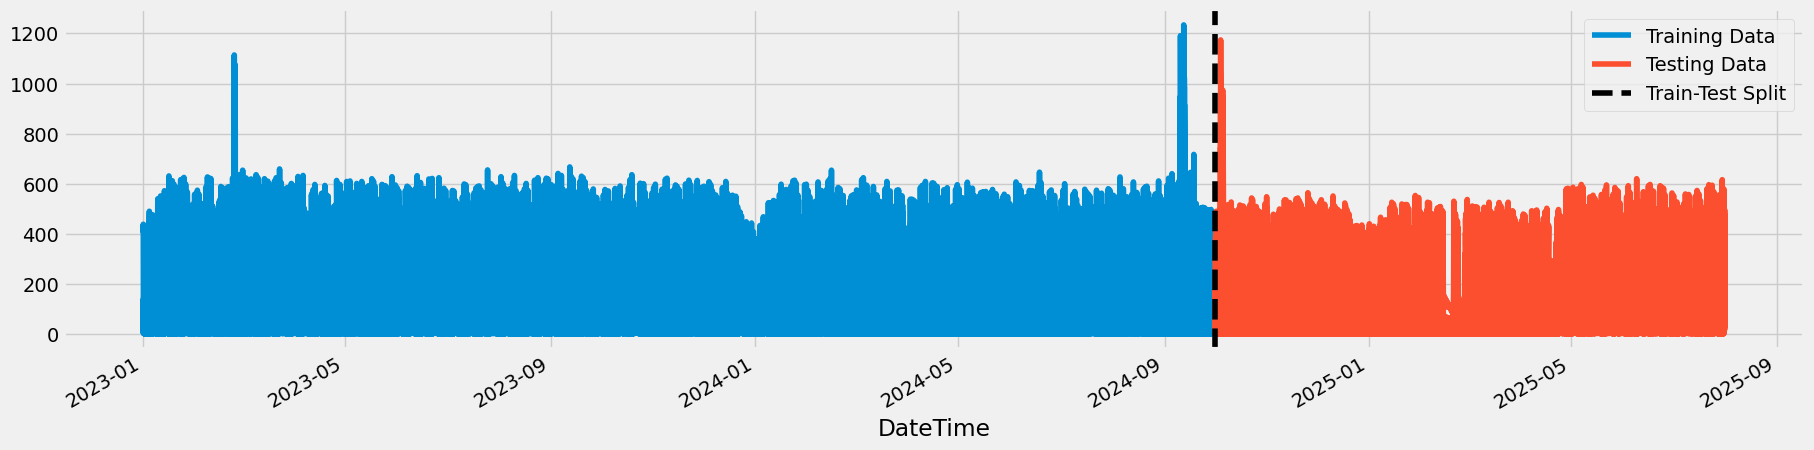

In [199]:
train = sub_df.loc[sub_df.index < '2024-10-01']
test = sub_df.loc[sub_df.index >= '2024-10-01']
fig, ax = plt.subplots(figsize=(20, 5))
train['Volume'].plot(ax=ax, label='Training Data')
test['Volume'].plot(ax=ax, label='Testing Data')
plt.axvline('2024-10-01', color='black', linestyle='--', label='Train-Test Split')
plt.legend()
plt.show()

In [200]:
## Feature Creation
def create_time_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

In [201]:
sub_df = create_time_features(sub_df)

In [202]:
train = create_time_features(train)
test = create_time_features(test)
FEATURES = ['Detector_ID', 'Lane', 'hour', 'day', 'dayofweek', 'month','year']
TARGET = 'Volume'

In [209]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [210]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate = 0.1)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=True)

[0]	validation_0-rmse:119.88310	validation_1-rmse:119.47920
[1]	validation_0-rmse:112.76318	validation_1-rmse:114.51695
[2]	validation_0-rmse:106.65022	validation_1-rmse:110.49040
[3]	validation_0-rmse:101.36444	validation_1-rmse:107.14987
[4]	validation_0-rmse:96.80997	validation_1-rmse:104.51096
[5]	validation_0-rmse:91.49910	validation_1-rmse:101.62531
[6]	validation_0-rmse:86.99995	validation_1-rmse:99.53611
[7]	validation_0-rmse:83.01532	validation_1-rmse:97.42324
[8]	validation_0-rmse:80.37610	validation_1-rmse:96.31756
[9]	validation_0-rmse:78.01745	validation_1-rmse:95.43879
[10]	validation_0-rmse:75.06879	validation_1-rmse:94.11529
[11]	validation_0-rmse:73.16907	validation_1-rmse:93.49998
[12]	validation_0-rmse:70.82329	validation_1-rmse:92.60677
[13]	validation_0-rmse:69.40756	validation_1-rmse:92.30329
[14]	validation_0-rmse:67.59645	validation_1-rmse:91.70198
[15]	validation_0-rmse:66.41809	validation_1-rmse:91.53165
[16]	validation_0-rmse:64.99402	validation_1-rmse:91.172

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [211]:
pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_)

,0
Detector_ID,0.000000
Lane,0.353492
hour,0.433666
day,0.026387
dayofweek,0.056039
month,0.044408
year,0.086009


In [212]:
test['prediction'] =reg.predict(X_test)

In [236]:
trydf = sub_df.merge(test[['Lane', 'prediction']], how='left', left_on=['Lane', sub_df.index], right_on=['Lane', test.index])
trydf.set_index('key_1', inplace=True)

In [325]:
def showTrafficVolumeWithPredictions(df):
    df = df[(df.index > '2025-07-01') & (df.index <= '2025-07-08') & (df['Lane'] == 6)] 
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.plot(sub_df.index, sub_df['prediction'], '-', label=f'Predictions Lane {lane}')
        ax.set_title(f'Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

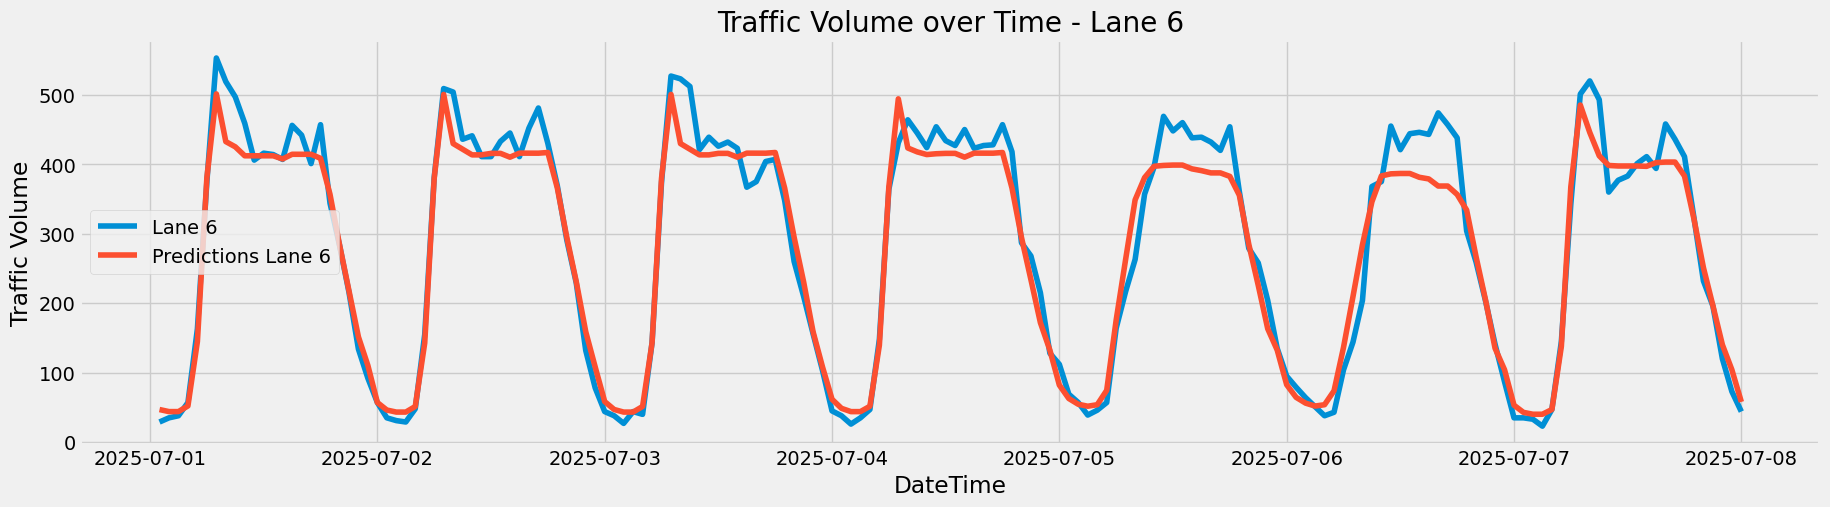

In [326]:
showTrafficVolumeWithPredictions(trydf)

In [294]:
average_traffic = pd.DataFrame()
average_traffic['average_volume'] = trydf.groupby(trydf.index).mean()['Volume']
average_traffic['average_prediction'] =trydf.groupby(trydf.index).mean()['prediction']

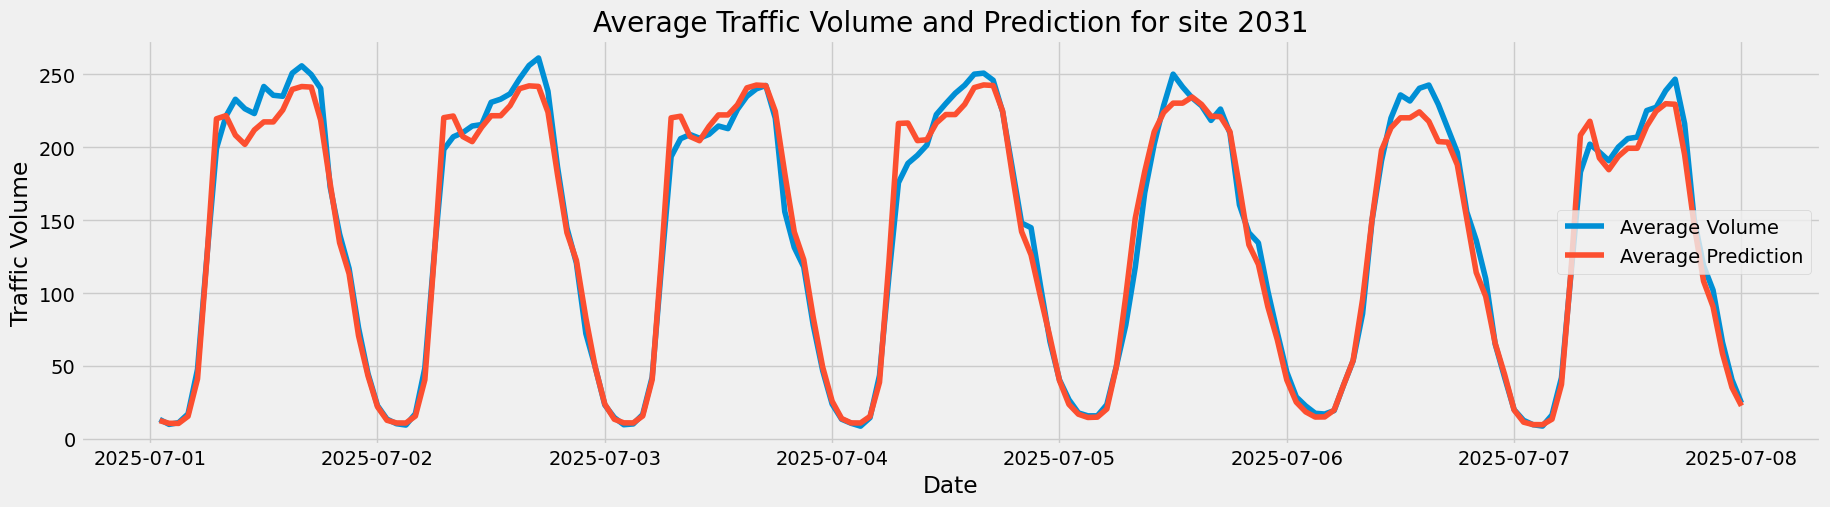

In [298]:
temp = average_traffic[(average_traffic.index > '2025-07-01') & (average_traffic.index <= '2025-07-08')] 
plt.figure(figsize=(20, 5))
plt.plot(temp.index, temp['average_volume'], label='Average Volume')
plt.plot(temp.index, temp['average_prediction'], label='Average Prediction')
plt.title('Average Traffic Volume and Prediction for site 2031')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()

In [253]:
import shap
import tqdm as notebook_tqdm

In [254]:
background = X_train.sample(min(1000, len(X_train)), random_state=42)

explainer = shap.TreeExplainer(reg, feature_perturbation="tree_path_dependent")

In [255]:
# choose a set to explain
X_explain = X_test  # or X_test

# for speed on big sets, sample
X_explain_sample = X_explain.sample(min(5000, len(X_explain)), random_state=42)

# SHAP values: returns array (n_samples, n_features)
shap_values = explainer.shap_values(X_explain_sample)
# Expected value (model base value)
base_value = explainer.expected_value


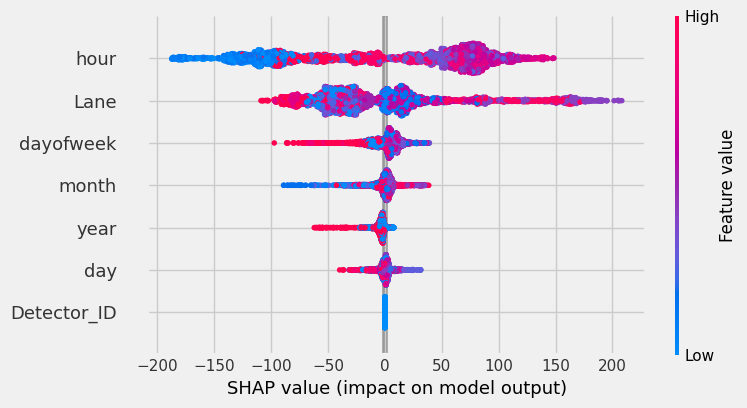

In [ ]:
shap.summary_plot(shap_values, X_explain_sample, show=True)

In [267]:
X_explain[X_explain['Lane'] == 5].iloc[[8]]

,Detector_ID,Lane,hour,day,dayofweek,month,year
DateTime,,,,,,,
2024-10-01 08:00:00,2013,5,8,1,1,10,2024


In [301]:
test[test['Lane'] == 5].iloc[[0]]

,Detector_ID,Lane,Volume,hour,day,dayofweek,month,year,prediction
DateTime,,,,,,,,,
2024-10-01,2013,5,0,0,1,1,10,2024,3.20968


In [308]:
test[test['Lane'] == 6].iloc[[7272]]

,Detector_ID,Lane,Volume,hour,day,dayofweek,month,year,prediction
DateTime,,,,,,,,,
2025-07-31,2013,6,44,0,31,3,7,2025,60.414272


In [314]:
test[(test['Lane'] == 6) & (test.index == '2025-07-04 00:00:00')]

,Detector_ID,Lane,Volume,hour,day,dayofweek,month,year,prediction
DateTime,,,,,,,,,
2025-07-04,2013,6,45,0,4,4,7,2025,61.721958


In [316]:
test[(test['Lane'] == 6) & (test.index == '2025-07-04 08:00:00')]

,Detector_ID,Lane,Volume,hour,day,dayofweek,month,year,prediction
DateTime,,,,,,,,,
2025-07-04 08:00:00,2013,6,464,8,4,4,7,2025,423.454651


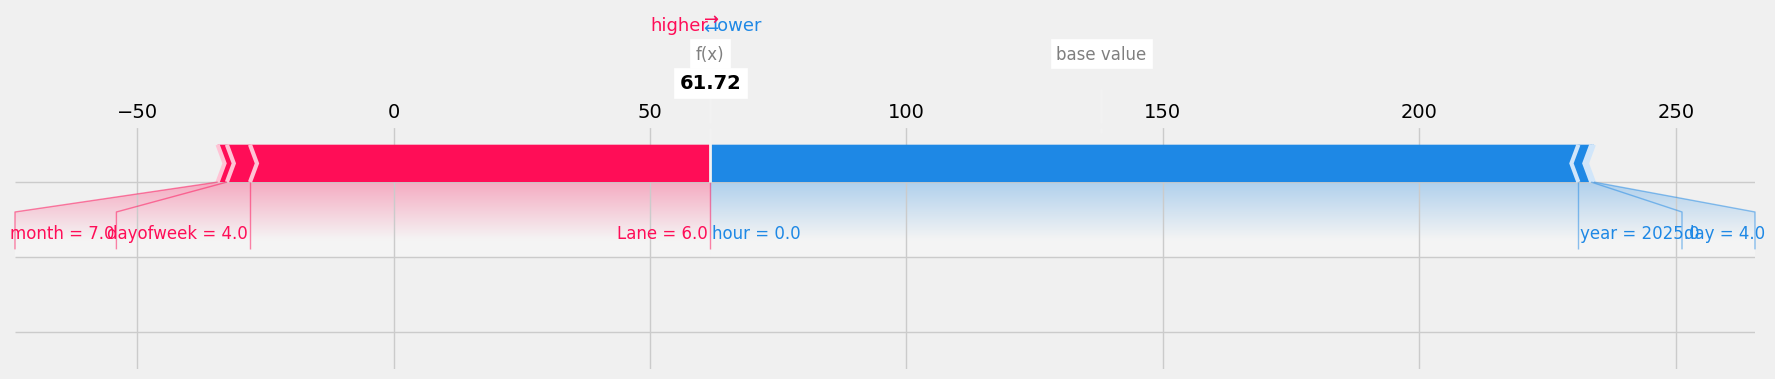

In [317]:
row = X_explain[(X_explain['Lane'] == 6) & (X_explain.index == '2025-07-04 00:00:00')]  # replace with your specific row selection

sv_row = explainer.shap_values(row)
shap.force_plot(base_value, sv_row, row, matplotlib=True)  # inline plot
plt.show()

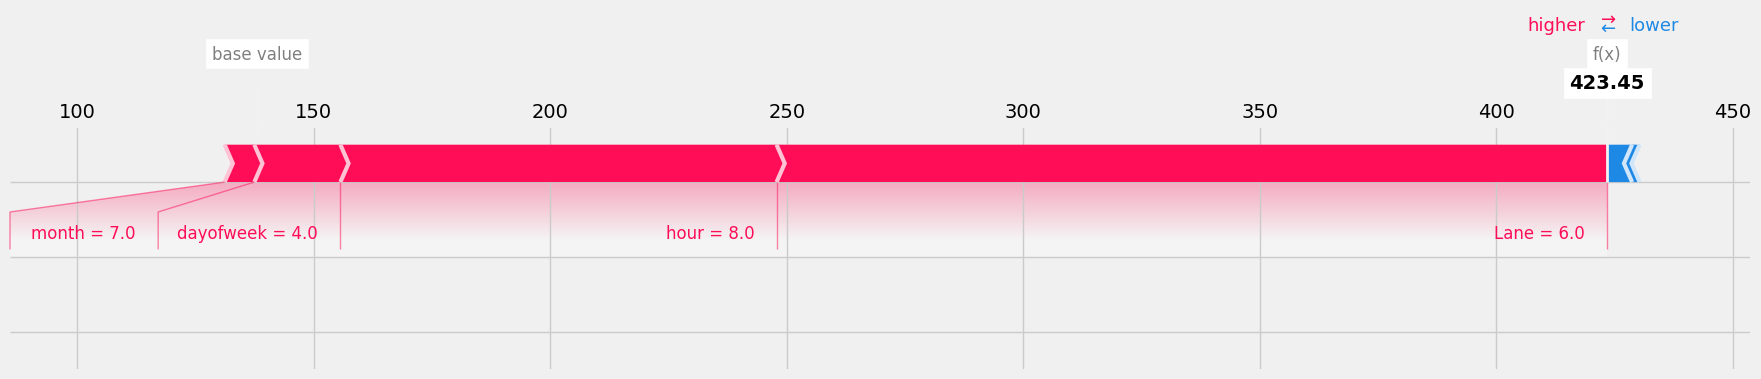

In [318]:
row = X_explain[(X_explain['Lane'] == 6) & (X_explain.index == '2025-07-04 08:00:00')]  # replace with your specific row selection

sv_row = explainer.shap_values(row)
shap.force_plot(base_value, sv_row, row, matplotlib=True)  # inline plot
plt.show()

In [320]:
print("Base value:", explainer.expected_value)

Base value: 137.98303


In [321]:
test['prediction'].mean()

np.float32(132.75108)